In [1]:
import numpy as np
import pandas as pd 
import os
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import backend as K
import keras
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
import skimage.io
from skimage.transform import resize

from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score

import keras.callbacks as callbacks
from keras.callbacks import Callback
get_ipython().run_line_magic('config', 'InlineBackend.figure_format="svg"')
get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore")
SIZE = 224
NUM_CLASSES = 2

from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
%matplotlib inline


2022-07-06 10:17:54.893947: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-06 10:17:54.898168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 10:17:54.898182: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/arman/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.model_selection import train_test_split


In [3]:
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler


def get_num_input():
    df = pd.read_csv('Ad.csv')
    df = df.drop(['filename'],axis=1)
    columns = list(df.columns)
    features = columns[:-1]
    cls_name = columns[-1]
    X = np.zeros((len(df), len(features)))
    Y = list()
    for i, row in df.iterrows():
        X[i] = row[features]                    
        Y.append(row[cls_name])

    return (X, Y)
X_num, Y = get_num_input()
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split( X_num, Y, test_size=0.2,random_state=42)

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras import regularizers
from keras.layers import Dropout 
def compile_model():
    num_input = Input(shape=(133,))        ## branch 2 with numerical input
    x1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(num_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    x1 = Dropout(0.3)(x1)
    out_b = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x1)
    out_b = Dense(1, activation='sigmoid')(out_b)
    model = Model(num_input, out_b)
    adam = Adam(lr=0.001, decay=1e-5)
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model

In [5]:
model = compile_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 133)]             0         
                                                                 
 dense (Dense)               (None, 1024)              137216    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0     

2022-07-06 10:18:07.788803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/arman/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-06 10:18:07.788826: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 10:18:07.788839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arman): /proc/driver/nvidia/version does not exist
2022-07-06 10:18:07.789097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None


In [6]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history1=model.fit(X_audio_train, y_audio_train, batch_size=256, epochs=1000,
                            validation_data=(X_audio_test, y_audio_test), callbacks=[es])

Epoch 1/1000
67/67 [==============================] - 3s 26ms/step - loss: 14.6572 - accuracy: 0.8814 - val_loss: 9.0315 - val_accuracy: 0.9475
Epoch 2/1000
67/67 [==============================] - 2s 24ms/step - loss: 8.5287 - accuracy: 0.9063 - val_loss: 7.9786 - val_accuracy: 0.9475
Epoch 3/1000
67/67 [==============================] - 2s 23ms/step - loss: 7.3637 - accuracy: 0.9304 - val_loss: 6.8944 - val_accuracy: 0.9475
Epoch 4/1000
67/67 [==============================] - 2s 24ms/step - loss: 6.5203 - accuracy: 0.9377 - val_loss: 6.2734 - val_accuracy: 0.9475
Epoch 5/1000
67/67 [==============================] - 2s 24ms/step - loss: 5.8036 - accuracy: 0.9435 - val_loss: 5.5422 - val_accuracy: 0.9475
Epoch 6/1000
67/67 [==============================] - 2s 23ms/step - loss: 5.2019 - accuracy: 0.9450 - val_loss: 4.9549 - val_accuracy: 0.9475
Epoch 7/1000
67/67 [==============================] - 2s 24ms/step - loss: 4.6713 - accuracy: 0.9454 - val_loss: 4.4832 - val_accuracy: 0.947

In [7]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.savefig('fakeav_audio_acc.eps', format='eps')
    plt.show()

In [8]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig('fakeav_audio_loss.eps', format='eps')
    plt.show()

In [35]:
df=pd.DataFrame(history1.history)

In [39]:
df.to_csv('fakeavceleb_aud_net.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


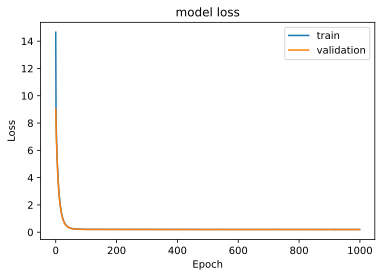

In [10]:
plot_loss(history1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


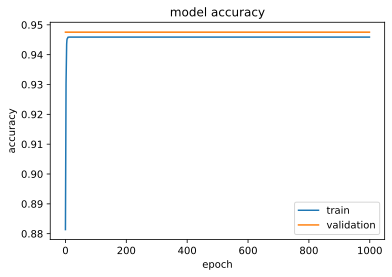

In [12]:
plot_hist(history1)

In [13]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_audio_train, y_audio_train, verbose=0)
test_loss, test_acc = model.evaluate(X_audio_test, y_audio_test, verbose=0)
print('Train_Loss: %.3f, Train_Acc: %.3f' % (train_loss, train_acc))
print('Test_Loss: %.3f, Test_Acc: %.3f' % (test_loss, test_acc))

Train_Loss: 0.195, Train_Acc: 0.946
Test_Loss: 0.194, Test_Acc: 0.948


In [14]:
pred = model.predict(X_audio_test)

133/133 [==============================] - 1s 4ms/step


In [15]:
y_pred = (model.predict(X_audio_test) > 0.5)*1

133/133 [==============================] - 1s 4ms/step


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
score = accuracy_score(y_audio_test, y_pred)
precision = precision_score(y_audio_test,y_pred)
recall = recall_score(y_audio_test,y_pred)
f1 = f1_score(y_audio_test,y_pred)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

score: 0.9475417548812044
Precision: 0.0
Recall: 0.0
F1_score: 0.0


In [17]:
# confusion matrix
matrix = confusion_matrix(y_audio_test, y_pred, labels=[0,1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[4028    0]
 [ 223    0]]


In [18]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_audio_test, y_pred, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      4028
           1       0.00      0.00      0.00       223

    accuracy                           0.95      4251
   macro avg       0.47      0.50      0.49      4251
weighted avg       0.90      0.95      0.92      4251



In [19]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_audio_test, y_pred,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 4028 0 223 0


In [20]:
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

def get_img_input():
    df = pd.read_csv('Vd.csv')
    columns = list(df.columns)
    features = columns[:-1]
    cls_name = columns[-1]
    X = np.zeros((len(df), len(features)))
    Y = list()
    for i, row in df.iterrows():
        X[i] = row[features]                    
        Y.append(row[cls_name])

    return (X, Y)
X_img, Y_img = get_img_input()
encoder = LabelEncoder()
Y_img = encoder.fit_transform(Y_img)
X_img_train, X_img_test, y_img_train, y_img_test = train_test_split( X_img, Y_img, test_size=0.3,random_state=42)

In [21]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate
from keras.models import Model
import numpy as np
from keras import regularizers
from keras.layers import Dropout 
def compile_model():
    img_input = Input(shape=(50176,)) 
    ## branch 1 with image input
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(img_input)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    out_a = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    out_a = Dense(1, activation='sigmoid')(out_a)
    model = Model(img_input, out_a)
    adam = Adam(lr=0.001, decay=1e-5)
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    return model
    #x = MaxPooling2D((2, 2))(x)
    #x = Flatten()(x)
    #out_a = Dense(64)(x)

    

In [22]:
model = compile_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50176)]           0         
                                                                 
 dense_7 (Dense)             (None, 1024)              51381248  
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0   

In [23]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
history2=model.fit(X_img_train, y_img_train, batch_size=256, epochs=1000,
                            validation_data=(X_img_test, y_img_test), callbacks=[es])

Epoch 1/1000
59/59 [==============================] - 14s 219ms/step - loss: 155.3273 - accuracy: 0.9190 - val_loss: 38.6815 - val_accuracy: 0.9694
Epoch 2/1000
59/59 [==============================] - 12s 203ms/step - loss: 49.8872 - accuracy: 0.9287 - val_loss: 31.2612 - val_accuracy: 0.9694
Epoch 3/1000
59/59 [==============================] - 12s 203ms/step - loss: 34.4430 - accuracy: 0.9351 - val_loss: 25.5541 - val_accuracy: 0.9694
Epoch 4/1000
59/59 [==============================] - 12s 203ms/step - loss: 26.8122 - accuracy: 0.9330 - val_loss: 21.9566 - val_accuracy: 0.9694
Epoch 5/1000
59/59 [==============================] - 12s 201ms/step - loss: 22.7347 - accuracy: 0.9312 - val_loss: 19.0775 - val_accuracy: 0.7048
Epoch 6/1000
59/59 [==============================] - 12s 202ms/step - loss: 19.3736 - accuracy: 0.9376 - val_loss: 16.5245 - val_accuracy: 0.9611
Epoch 7/1000
59/59 [==============================] - 12s 203ms/step - loss: 16.8165 - accuracy: 0.9344 - val_loss: 1

In [24]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.savefig('fakeav_video_acc.eps', format='eps')
    plt.show()

In [25]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig('fakeav_video_loss.eps', format='eps')
    plt.show()

In [40]:
df=pd.DataFrame(history2.history)
df.to_csv('fakeavceleb_vis_net.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


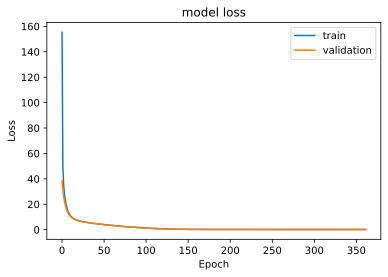

In [26]:
plot_loss(history2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


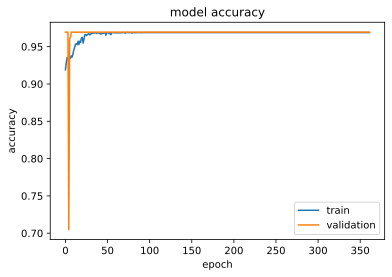

In [27]:
plot_hist(history2)

In [28]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_img_train, y_img_train, verbose=0)
test_loss, test_acc = model.evaluate(X_img_test, y_img_test, verbose=0)
print('Train_Loss: %.3f, Train_Acc: %.3f' % (train_loss, train_acc))
print('Test_Loss: %.3f, Test_Acc: %.3f' % (test_loss, test_acc))

Train_Loss: 0.139, Train_Acc: 0.969
Test_Loss: 0.137, Test_Acc: 0.969


In [29]:
pred = model.predict(X_img_test)

200/200 [==============================] - 3s 14ms/step


In [30]:
y_pred = (model.predict(X_img_test) > 0.5)*1

200/200 [==============================] - 3s 14ms/step


In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
score = accuracy_score(y_img_test, y_pred)
precision = precision_score(y_img_test,y_pred)
recall = recall_score(y_img_test,y_pred)
f1 = f1_score(y_img_test,y_pred)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

score: 0.9694165621079046
Precision: 0.0
Recall: 0.0
F1_score: 0.0


In [32]:
# confusion matrix
matrix = confusion_matrix(y_img_test, y_pred, labels=[0,1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[6181    0]
 [ 195    0]]


In [33]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_img_test, y_pred, labels=[0,1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      6181
           1       0.00      0.00      0.00       195

    accuracy                           0.97      6376
   macro avg       0.48      0.50      0.49      6376
weighted avg       0.94      0.97      0.95      6376



In [34]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_img_test, y_pred,labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 6181 0 195 0
